This notebook contains the code for the sentiment analysis with detailed explaination of the approach as well as concepts used for the model development.

**Sentiment analysis** can tell you which customers feel negatively about your brand for whatever reason, providing you an opportunity to address their concerns and plan product improvement.

***Sentiment analysis***:

The process of  identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is called as Sentiment Analysis

***Example***:

**Positive Sentiment**: The phone is awesome!

**Negative Sentiment**: We lost!

***Problem Statement***:

The objective of this task is to detect hate speech in tweets.

For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist.

***Objective***:

To build model that identifies the sentiment of a text.




In [0]:
import pandas as pd   #data processing
import re             #regular expressions
import seaborn as sns #data visualization
import numpy as np    #array processing
import matplotlib.pyplot as plt  #data visualization
from bs4 import BeautifulSoup    #handling HTML 
from collections import Counter  #container datatypes
from wordcloud import WordCloud  #data visualization
from nltk.corpus import stopwords# Natural Language toolkit
from sklearn.feature_extraction.text import TfidfTransformer #TF-IDF
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 
from imblearn.over_sampling import SMOTE     #Oversampling
from imblearn.pipeline import make_pipeline  #Pipeline is just an abstract notion for performing sequence of different transformations
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, StratifiedKFold
from nltk.stem import WordNetLemmatizer      #Lemmatization
from nltk.tokenize import WordPunctTokenizer #Tokenizer
nltk.download('all') 

import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [0]:
data=pd.read_csv("train_E6oV3lV.csv")
data.info() #Datatypes, dimensions of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [0]:
data.head() #display first 5 rows

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i cannot use cause they do not offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [0]:
data = data.drop(['id'],axis=1) #drop unnecessary columns
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i cannot use cause they do not offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


In [0]:
#Understanding class distribution
positives = data['label'][data.label == 0]
negatives = data['label'][data.label == 1]
print('Number of positve tagged sentences is:  {}'.format(len(positives)))
print('Number of negative tagged sentences is: {}'.format(len(negatives)))
print('Total length of the data is:            {}'.format(data.shape[0]))

Number of positve tagged sentences is:  29720
Number of negative tagged sentences is: 2242
Total length of the data is:            31962


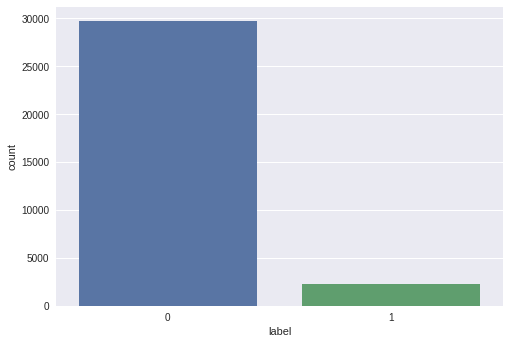

In [0]:
sns.countplot(x="label", data=data) 

In [0]:
print('Propotion of positive tagged sentences is:  {}'.format(len(positives)/data.shape[0]))
print('Propotion of negative tagged sentences is: {}'.format(len(negatives)/data.shape[0]))

Propotion of positive tagged sentences is:  0.9298542018647143
Propotion of negative tagged sentences is: 0.07014579813528565


**Data Cleaning**

1.The raw data is messy. It contains hashtags, user mentions, non ascii characters, punctuations, numbers, html entities, extra spaces, misspelled words,etc.

2.So, Data Pre-processing is the most important step prior to the model building in which we remove all the unnecessary qualities from the data.

Let us look at some of the examples


***HTML decode***:-

HTML encoding has not been converted to text and ended up in text field as ‘&amp’,’&quot’,etc. Decoding HTML to general text will be my first step of data preprocessing.

In [0]:
data.tweet[22]  #html decoding

"product of the day: happy man #wine tool  who's   it's the #weekend? time to open up &amp; drink up!"

In [0]:
example1 = BeautifulSoup(data.tweet[22], 'lxml')
print(example1.get_text())

product of the day: happy man #wine tool  who's   it's the #weekend? time to open up & drink up!


***Contraction Mapping***

In [0]:
data.tweet[1] #converting don't to "do not"

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [0]:
data.tweet[1].replace('don\'t','do not')

"@user @user thanks for #lyft credit i can't use cause they do not offer wheelchair vans in pdx.    #disapointed #getthanked"

***UTF-8 BOM*** :- 

By looking at the above entry, I can see strange patterns of characters “\xef\xbf\xbd”. After some researching, I found that these are UTF-8 BOM.

The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8.”

Let us ignore these bytes.



In [0]:
data.tweet[3]

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

In [0]:
newString = (data.tweet[3].encode('ascii', 'ignore')).decode("utf-8")
newString

'#model   i love u take with u all the time in ur!!!   '

**Removal of Hashtag symbol & User mentions**

Sometimes the text used with hashtag can provide useful information about the tweet. It might be a bit risky to get rid of all the text together with the hashtag.
So I decided to leave the text intact and just remove the ‘#’. 

In [0]:
data.tweet[1]

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [0]:
import re
newString=re.sub(r'@[A-Za-z0-9]+','',data.tweet[1])
newstring=newString.replace("#","")
newstring

"  thanks for lyft credit i can't use cause they don't offer wheelchair vans in pdx.    disapointed getthanked"

***Removal of Numbers, Punctuations, Special Characters ***

In [0]:
data.tweet[8]

'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ '

In [0]:
re.sub("[^a-zA-Z]", " ", data.tweet[8])

'we won    love the land     allin  cavs  champions  cleveland  clevelandcavaliers      '

***Removal of short words***

In [0]:
new_sentence=''
for i in data.tweet[8].split():
  if len(i)>3:
    new_sentence=new_sentence+i+' '
new_sentence

'won!!! love land!!! #allin #cavs #champions #cleveland #clevelandcavaliers '

***Text Normalization***

There are 2 types of normalization techniques:-

1.**Stemming** is the process of converting the words of a sentence to its non-changing portions. In the example of amusing, amusement, and amused above, the stem would be amus.

2.**Lemmatization** is the process of converting the words of a sentence to its dictionary form. For example, given the words amusement, amusing, and amused, the lemma for each and all would be amuse.

Here, I prefer Lemmatization over Stemming since lemma results in dictionary form.

In [0]:
data.tweet[5]

'[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  '

In [0]:
lemmatizer = WordNetLemmatizer() 
new_sentence=''
for i in data.tweet[5].split():
  new_sentence=new_sentence+lemmatizer.lemmatize(i)+' '
new_sentence

'[2/2] huge fan fare and big talking before they leave. chaos and pay dispute when they get there. #allshowandnogo '

***Pre-Processing of Tweets***

In [0]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text
  
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have" }  

data['tweet'] = data['tweet'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [0]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i cannot use cause they do not offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


In [0]:
tok = WordPunctTokenizer()

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')                             #decode html
    souped = soup.get_text()                                       #get text
    newString = (souped.encode('ascii', 'ignore')).decode("utf-8") #encode to ascii
    newString=re.sub(r'@[A-Za-z0-9]+','',newString)                #removing user mentions
    letters_only = re.sub("[^a-zA-Z]", " ", newString)             #Fetching out only ascii characters
    lower_case = letters_only.lower()                              #converting everything to lowercase
    words = tok.tokenize(lower_case)                               #tokenize and join together to remove white spaces between words
    long_words=[]
    for i in words:
      if len(i)>3:                                                 #removing short words
        long_words.append(lemmatizer.lemmatize(i))                 #converting words to lemma
    return (" ".join(long_words)).strip()                          #combining to form sentence
  
cleaned_tweets = []
for t in data.tweet:
  cleaned_tweets.append(tweet_cleaner(t))
cleaned_tweets[:5]

['when father dysfunctional selfish drag kid into dysfunction',
 'thanks lyft credit cannot cause they offer wheelchair van disapointed getthanked',
 'bihday your majesty',
 'model love take with time',
 'factsguide society motivation']

In [0]:
data['cleaned_tweets']=cleaned_tweets #creating new dataframe

In [0]:
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['cleaned_tweets'].apply(word_count) 
data.head()

,label,tweet,cleaned_tweets,word count
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drag kid into dysfunction,8
1,0,@user @user thanks for #lyft credit i cannot use cause they do not offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit cannot cause they offer wheelchair van disapointed getthanked,11
2,0,bihday your majesty,bihday your majesty,3
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love take with time,5
4,0,factsguide: society now #motivation,factsguide society motivation,3


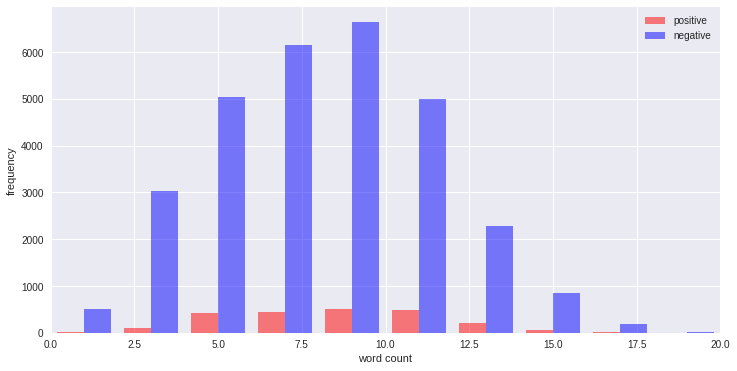

In [0]:
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.label == 1]
y = data['word count'][data.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,20)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [0]:
# get most common words in training dataset
all_words = []
for line in list(data['cleaned_tweets']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('love', 2874),
 ('this', 2686),
 ('with', 2531),
 ('that', 2061),
 ('have', 2018),
 ('your', 1704),
 ('happy', 1700),
 ('will', 1625),
 ('just', 1365),
 ('when', 1269)]

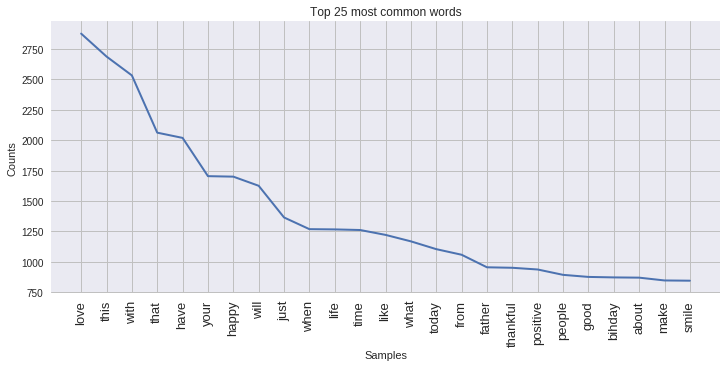

In [0]:
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

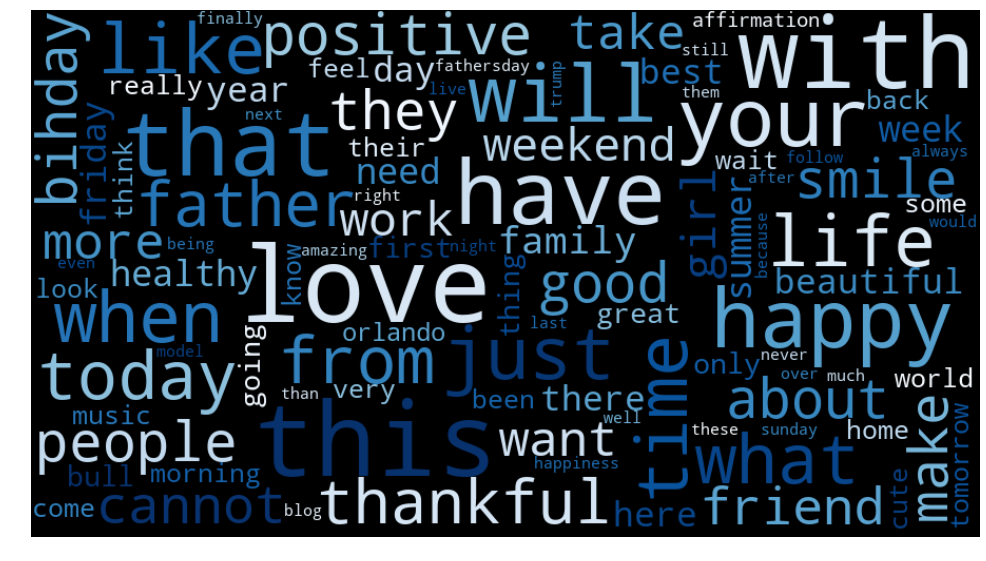

In [0]:
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=100,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us dive into the concept of embeddings

***Why embeddings?***

Machine Learning algorithm can understand only numbers but not raw string. Thats the reason why we have to convert the text to numeric form before feeding into machine learning model.

***Embeddings***:

Embeddings are the numerical representation of the text.

***Different types of embeddings***:

1. Frequency based:- Count Vectorizer, TF-IDF

2. Prediction based:- Word2Vec

***Feature Extraction ***

**Term Frequency-Inverse Document Frequency**

1.TF-IDF, short for term frequency–inverse document frequency, is a numeric measure that is use to score the importance of a word in a document based on how often did it appear in that document and a given collection of documents. 

2.The intuition for this measure is : If a word appears frequently in a document, then it should be important and we should give that word a high score. But if a word appears in too many other documents, it’s probably not a unique identifier, therefore we should assign a lower score to that word. 

3,The math formula for this measure :

tfidf(t,d,D)=tf(t,d)×idf(t,D)

Where t denotes the terms; d denotes each document; D denotes the collection of documents.

Let us build the feature space using **TF-IDF**

In [0]:
tvec = TfidfVectorizer(stop_words=None, max_features=1000,min_df=2) #max_features=Max no. of words to be considered, min-df=Min frequency of word 
tfidf = tvec.fit_transform(data['cleaned_tweets'])
tfidf.shape  #every document is represented with 1000 features

(31962, 1000)

**Original Imbalance Dataset**

In [0]:
y=np.array(data.label)
x_tr,x_val,y_tr,y_val=train_test_split(tfidf,y,test_size=0.2,random_state=77,stratify=y) #Split data into training and validation data initially

***TF-IDF + Logistic Regression + Imbalanced dataset***

In [0]:
lr = LogisticRegression()
lr_fit =lr.fit(x_tr,y_tr)
prediction = lr_fit.predict(x_val)
print(classification_report(y_val,prediction))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5945
           1       0.85      0.36      0.51       448

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.90      0.68      0.74      6393
weighted avg       0.95      0.95      0.94      6393



Let us find **F1 score** at various thresholds to obtain the** optimal threshold** value

In [0]:
from sklearn import metrics
pred_noemb_val_y  = lr_fit.predict_proba(x_val)
for thresh in np.arange(0.1, 0.501, 0.01):
  thresh = np.round(thresh, 2)
  print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_noemb_val_y[:,1]>thresh).astype(int),average='macro')))

F1 score at threshold 0.1 is 0.713842684316272
F1 score at threshold 0.11 is 0.7267499239716226
F1 score at threshold 0.12 is 0.7352665144591886
F1 score at threshold 0.13 is 0.7449644632565681
F1 score at threshold 0.14 is 0.7496013185367735
F1 score at threshold 0.15 is 0.7523346502827065
F1 score at threshold 0.16 is 0.7539667412137407
F1 score at threshold 0.17 is 0.7588031152778568
F1 score at threshold 0.18 is 0.7615749579905577
F1 score at threshold 0.19 is 0.7691300504771409
F1 score at threshold 0.2 is 0.7751990190195766
F1 score at threshold 0.21 is 0.7745051355485777
F1 score at threshold 0.22 is 0.777520450190937
F1 score at threshold 0.23 is 0.7779002951000649
F1 score at threshold 0.24 is 0.7803743986136762
F1 score at threshold 0.25 is 0.778267021083593
F1 score at threshold 0.26 is 0.7804959813417058
F1 score at threshold 0.27 is 0.7757465934468486
F1 score at threshold 0.28 is 0.7759149348849804
F1 score at threshold 0.29 is 0.7773307728341452
F1 score at threshold 0.3

**Observation**:


1.F1 score at threshold 0.26 out performs the F1 score at threshold 0.5.

2.We achieve the maximum F1 score at threshold 0.26. Hence, Optimal threshold value would be 0.26.

3.So, we can infer that thresold at 0.5 is not always the optimal one.

Let us handle the class imbalance problem now using 2 techniques

***Class Weights***

We can overcome the class imbalance problem by increasing the importance to the minority class samples by assigning higher class weights to minory class.

  ***TF-IDF + Logistic Regression + Auto Balanced Class Weights***

scikit module automatically assigns the class weights depending upon the class distribution.

Let us try with that initially.



In [0]:
lr = LogisticRegression(class_weight='balanced')

# Fit..
lr.fit(x_tr, y_tr)

# Predict..
y_pred = lr.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5945
           1       0.33      0.80      0.47       448

   micro avg       0.87      0.87      0.87      6393
   macro avg       0.66      0.84      0.70      6393
weighted avg       0.94      0.87      0.89      6393



In [0]:
from sklearn import metrics
pred_noemb_val_y  = lr.predict_proba(x_val)
for thresh in np.arange(0.1, 0.501, 0.01):
  thresh = np.round(thresh, 2)
  print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_noemb_val_y[:,1]>thresh).astype(int),average='macro')))

F1 score at threshold 0.1 is 0.41604238774073404
F1 score at threshold 0.11 is 0.4312869119073658
F1 score at threshold 0.12 is 0.4428971446244569
F1 score at threshold 0.13 is 0.45458493187961785
F1 score at threshold 0.14 is 0.4664461682429697
F1 score at threshold 0.15 is 0.4757690757590949
F1 score at threshold 0.16 is 0.4864770608601724
F1 score at threshold 0.17 is 0.496202505342448
F1 score at threshold 0.18 is 0.5049030381423677
F1 score at threshold 0.19 is 0.5140011432434443
F1 score at threshold 0.2 is 0.5224043769504177
F1 score at threshold 0.21 is 0.532553538441356
F1 score at threshold 0.22 is 0.5406318529849479
F1 score at threshold 0.23 is 0.5470114860842165
F1 score at threshold 0.24 is 0.5533511185861651
F1 score at threshold 0.25 is 0.5603504531040425
F1 score at threshold 0.26 is 0.5652285137611233
F1 score at threshold 0.27 is 0.5701568852288126
F1 score at threshold 0.28 is 0.5759841612982057
F1 score at threshold 0.29 is 0.5822695604708813
F1 score at threshold 

***K Cross Fold Validation***:

K-Fold Cross-Validation splits your data into k folds, use each fold as validation data and use rest of the data as training data and validate against testing data. Repeat the process k times. And Get the average performance.

k-fold cross validation especially useful for small dataset since it maximizes both the validation and training data.

***Stratified K Cross fold validation*** 

It preserves the proportion of class distribution same across all the folds so that each fold is good representative of the training data set.

 ***Grid Search CV***

For every combination of parameters, run k Cross Fold Validation and mean of F1 score is considered to evaluate the best parameter set.

***Tuning Class Weights ***

We can also tune the class weights manually to find a better trade-off between false positives, false negatives. The F1 score is a metric that attempts to take that tradeoff.


Best parameters : {'class_weight': {0: 0.14894736842105263, 1: 0.8510526315789474}}


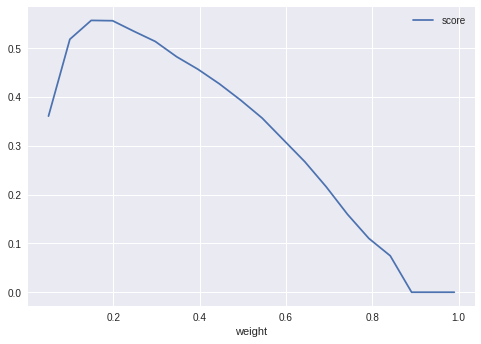

In [0]:
weights = np.linspace(0.05, 0.99, 20)

kf = StratifiedKFold(n_splits = 3)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=kf
)
grid_result = gsc.fit(tfidf, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

***TF-IDF + Logistic Regression + Optimal parameter set of Class Weights***

Now we create a logistic regression with the optimum parameters we discovered above and plot results again. This version reseults in a more balanced tradeoff between false positives, false negatives.

In [0]:
lr = LogisticRegression(**grid_result.best_params_)

# Fit..
lr.fit(x_tr, y_tr)

# Predict..
y_pred = lr.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.57      0.59      0.58       448

   micro avg       0.94      0.94      0.94      6393
   macro avg       0.77      0.78      0.77      6393
weighted avg       0.94      0.94      0.94      6393



In [0]:
pred_noemb_val_y  = lr.predict_proba(x_val)
for thresh in np.arange(0.1, 0.501, 0.01):
  thresh = np.round(thresh, 2)
  print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_noemb_val_y[:,1]>thresh).astype(int),average='macro')))

F1 score at threshold 0.1 is 0.35127086744584346
F1 score at threshold 0.11 is 0.37637094624327755
F1 score at threshold 0.12 is 0.40367914536707855
F1 score at threshold 0.13 is 0.42755805948078696
F1 score at threshold 0.14 is 0.44998001849396796
F1 score at threshold 0.15 is 0.4688083923345311
F1 score at threshold 0.16 is 0.4887290729654591
F1 score at threshold 0.17 is 0.5067542624705521
F1 score at threshold 0.18 is 0.5243646050831594
F1 score at threshold 0.19 is 0.5411913897885772
F1 score at threshold 0.2 is 0.5588483403617771
F1 score at threshold 0.21 is 0.5725207286992184
F1 score at threshold 0.22 is 0.5839564146091888
F1 score at threshold 0.23 is 0.5964199370947538
F1 score at threshold 0.24 is 0.6073957944281796
F1 score at threshold 0.25 is 0.6184316767933067
F1 score at threshold 0.26 is 0.6321054727045237
F1 score at threshold 0.27 is 0.6551111170557826
F1 score at threshold 0.28 is 0.6628936279063505
F1 score at threshold 0.29 is 0.6730563105405266
F1 score at thres

**Observation**

1.Auto balancing of scikit class weights resulted in poor results where as parameter tuning of class 
weights resulted in the better F1 score.

2.We achieved a better F1 score compared to the model trained on imbalanced dataset.

***OVER SAMPLING***

Another way of handling class imbalance problem is to increase the no. of minority samples so that minority samples are equal in number as the majority samples.

***Synthetic Minority Oversampling Technique***

SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.

***Math behind SMOTE ***:-

1.Consider a feature vector randomly and look at its k nearest neighbors.

2.Select one of the k nearest neighbors randomly and take the difference of feature vector and k nearest neighbor.

3.The random number between (0,1) is generated and is mulitplied with difference and added to the feature vector which is chosen as reference.

***TF-IDF+ Logistic Regression + SMOTE***

In [0]:
pipe = make_pipeline(
    SMOTE(random_state=777),
    LogisticRegression()
)

# Fit..
pipe.fit(x_tr, y_tr)

# Predict..
y_pred = pipe.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5945
           1       0.33      0.77      0.46       448

   micro avg       0.87      0.87      0.87      6393
   macro avg       0.66      0.83      0.70      6393
weighted avg       0.94      0.87      0.90      6393



In [0]:
from sklearn import metrics
pred_noemb_val_y  = pipe.predict_proba(x_val)
for thresh in np.arange(0.1, 0.501, 0.01):
  thresh = np.round(thresh, 2)
  print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_noemb_val_y[:,1]>thresh).astype(int),average='macro')))

F1 score at threshold 0.1 is 0.47862064548399097
F1 score at threshold 0.11 is 0.4895693080656351
F1 score at threshold 0.12 is 0.49981369313735835
F1 score at threshold 0.13 is 0.5105643636898753
F1 score at threshold 0.14 is 0.5218536024717242
F1 score at threshold 0.15 is 0.5307983092108466
F1 score at threshold 0.16 is 0.5390825509578925
F1 score at threshold 0.17 is 0.5479138609060563
F1 score at threshold 0.18 is 0.5523263757462147
F1 score at threshold 0.19 is 0.5606910424113074
F1 score at threshold 0.2 is 0.566977361773479
F1 score at threshold 0.21 is 0.5726396562780509
F1 score at threshold 0.22 is 0.5783715603336699
F1 score at threshold 0.23 is 0.5870352935870586
F1 score at threshold 0.24 is 0.5918822166841027
F1 score at threshold 0.25 is 0.5960097722768849
F1 score at threshold 0.26 is 0.6017743229364907
F1 score at threshold 0.27 is 0.6063335497883965
F1 score at threshold 0.28 is 0.6139233839853321
F1 score at threshold 0.29 is 0.618003993462403
F1 score at threshold 

***Tuning SMOTE ratio using Grid Search CV***

**SMOTE ratio** 

1.SMOTE ratio is defined as ratio of no. of minority samples to no. of majority samples

2.SMOTE approach suffers a similar issue as the auto-balancing of weights by sklearn LogisticRegression. 

We can tune SMOTE re-sampling and achieve a similar effect...


Best parameters : {'smote__ratio': 0.225}


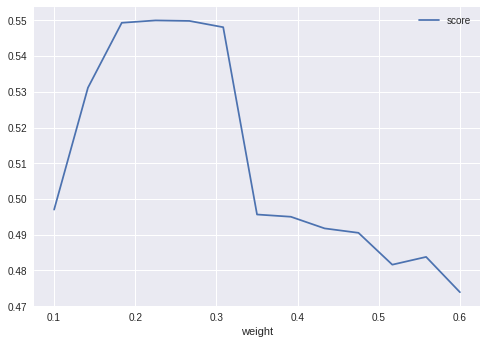

In [0]:
pipe = make_pipeline(
    SMOTE(),
    LogisticRegression()
)

weights = np.linspace(0.1,0.6,13)

kf = StratifiedKFold(n_splits = 3)

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        #'smote__ratio': [{0: int(num_neg), 1: int(num_neg * w) } for w in weights]
        'smote__ratio': weights
    },
    scoring='f1',
    cv=kf
)
grid_result = gsc.fit(tfidf, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

***TF-IDF + Logistic Regression + Optimal parameter set of SMOTE***

Now we create a logistic regression with the optimum parameters we discovered above and plot results again. This version reseults in a more balanced tradeoff between false positives, false negatives.

In [0]:
pipe = make_pipeline(
    SMOTE(random_state=777,ratio=0.225),
    LogisticRegression()
)

# Fit..
pipe.fit(x_tr, y_tr)

# Predict..
y_pred = pipe.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5945
           1       0.65      0.54      0.59       448

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.81      0.76      0.78      6393
weighted avg       0.94      0.95      0.94      6393



In [0]:
from sklearn import metrics
pred_noemb_val_y  = pipe.predict_proba(x_val)
for thresh in np.arange(0.1, 0.501, 0.01):
  thresh = np.round(thresh, 2)
  print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_noemb_val_y[:,1]>thresh).astype(int),average='macro')))

F1 score at threshold 0.1 is 0.5744316128099473
F1 score at threshold 0.11 is 0.5900299892491371
F1 score at threshold 0.12 is 0.6037618905669399
F1 score at threshold 0.13 is 0.6159787524852169
F1 score at threshold 0.14 is 0.6283679116536045
F1 score at threshold 0.15 is 0.6353347685419601
F1 score at threshold 0.16 is 0.6457532889683419
F1 score at threshold 0.17 is 0.6539951865651262
F1 score at threshold 0.18 is 0.6619235269015675
F1 score at threshold 0.19 is 0.6700599394852554
F1 score at threshold 0.2 is 0.6779677429293692
F1 score at threshold 0.21 is 0.6844244802371287
F1 score at threshold 0.22 is 0.6899446038339564
F1 score at threshold 0.23 is 0.6946193891413575
F1 score at threshold 0.24 is 0.6991724087804256
F1 score at threshold 0.25 is 0.7037145625822505
F1 score at threshold 0.26 is 0.7078556735526327
F1 score at threshold 0.27 is 0.7109638179627686
F1 score at threshold 0.28 is 0.7157519597765796
F1 score at threshold 0.29 is 0.7208483906829719
F1 score at threshold 

**Observation**

We have achieved almost similar results in case of **class weights** as well as **SMOTE**


***TF-IDF + Random Forests + Original Imbalanced dataset***

Let us build the random forest model on the TF-IDF features.

In [0]:
x_tr,x_val,y_tr,y_val=train_test_split(tfidf,y,test_size=0.2,random_state=77,stratify=y) #Split data into training and validation data initially

rf=RandomForestClassifier()

# Fit..
rf.fit(x_tr, y_tr)

# Predict..
y_pred = rf.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5945
           1       0.78      0.47      0.59       448

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.87      0.73      0.78      6393
weighted avg       0.95      0.95      0.95      6393



***TF-IDF + Random Forests + Auto Balanced Class Weights***

Scikit module automatically assigns the class weights depending upon the class distribution. Let us try with that initially

In [0]:
rf=RandomForestClassifier(class_weight='balanced')

# Fit..
rf.fit(x_tr, y_tr)

# Predict..
y_pred = rf.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5945
           1       0.50      0.58      0.54       448

   micro avg       0.93      0.93      0.93      6393
   macro avg       0.73      0.77      0.75      6393
weighted avg       0.93      0.93      0.93      6393



***Tuning Class Weights***

We can also tune the class weights manually to find a better trade-off between false positives, false negatives. The F1 score is a metric that attempts to take that tradeoff.

Below we explore the effect of weighting on F1 score to figure out the optimum.

Best parameters : {'class_weight': {0: 0.14894736842105263, 1: 0.8510526315789474}}


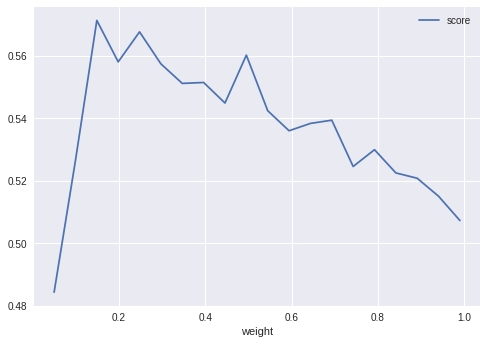

In [0]:
weights = np.linspace(0.05, 0.99, 20)

kf = StratifiedKFold(n_splits = 3)

gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=kf
)
grid_result = gsc.fit(tfidf, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

***TF-IDF + Random Forests + Optimal set of Class Weights***

In [0]:
rf = RandomForestClassifier(**grid_result.best_params_)

# Fit..
rf.fit(x_tr, y_tr)

# Predict..
y_pred = rf.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5945
           1       0.70      0.53      0.60       448

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.83      0.76      0.79      6393
weighted avg       0.95      0.95      0.95      6393



**Observation**

1.We achieved better F1 score compared to the model trained on imbalanced dataset

***TF-IDF + Random Forests + SMOTE ***

In [0]:
pipe = make_pipeline(
    SMOTE(random_state=777),
    RandomForestClassifier()
)

# Fit..
pipe.fit(x_tr, y_tr)

# Predict..
y_pred = pipe.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5945
           1       0.43      0.67      0.52       448

   micro avg       0.91      0.91      0.91      6393
   macro avg       0.70      0.80      0.74      6393
weighted avg       0.94      0.91      0.92      6393



***Tuning SMOTE ratio using GridSearchCV***

Best parameters : {'smote__ratio': 0.2142857142857143}


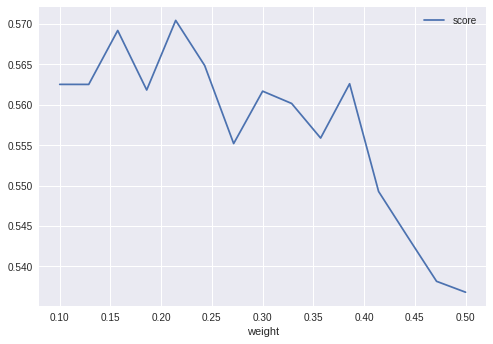

In [0]:
pipe = make_pipeline(
    SMOTE(),
    RandomForestClassifier()
)

kf = StratifiedKFold(n_splits = 3)


weights = np.linspace(0.1, 0.5, 15)

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        #'smote__ratio': [{0: int(num_neg), 1: int(num_neg * w) } for w in weights]
        'smote__ratio': weights
    },
    scoring='f1',
    cv=kf
)
grid_result = gsc.fit(tfidf, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

***TF-IDF + Random Forests + Optimal set of SMOTE ratio ***

In [0]:
pipe = make_pipeline(
    SMOTE(random_state=777,ratio=0.2142857142857143),
    RandomForestClassifier()
)

# Fit..
pipe.fit(x_tr, y_tr)

# Predict..
y_pred = pipe.predict(x_val)

# Evaluate the model

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5945
           1       0.65      0.59      0.62       448

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.81      0.78      0.80      6393
weighted avg       0.95      0.95      0.95      6393



**Observation**

1.We achieved better F1 score than the model with optimal Class Weights.

***Drawbacks of Count based embeddings***:-

1.Doesn't take context into consideration

2.That's why, we move on to Prediction based embeddings where the embeddings are learnt based on the context of the words in the sentence.

***Word2Vec***:-

1.The main idea of Word2Vec is "Similar words appering in the similar context tend to have similar 
embeddings".

Lets us build Word2Vec embeddings!


In [0]:
from gensim.models import Word2Vec
sentences = data['cleaned_tweets'].apply(lambda x: x.split()) # tokenizing

model = Word2Vec(sentences,min_count=1,sg=0,window=3,size=300) #sg=type of model,window=Context window, size=No. of features
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
# access vector for one word
print(model['love'])

Word2Vec(vocab=33338, size=300, alpha=0.025)
[-2.32326210e-01  2.60428131e-01  4.00829107e-01  1.43327817e-01
 -8.47651601e-01 -7.31646597e-01  3.89858964e-03  9.06750619e-01
  2.57328153e-01 -3.05891842e-01 -6.30551517e-01 -3.08218598e-01
  5.35176881e-03 -3.72380763e-02 -7.76189268e-01  2.40660354e-01
 -6.15314692e-02  7.17495143e-01 -5.39807439e-01 -2.05833595e-02
  7.24154592e-01 -3.32295865e-01  3.43610138e-01  8.33983064e-01
 -9.92533326e-01  2.75798649e-01  4.67553109e-01  3.15891802e-01
 -3.06110293e-01 -4.49076444e-02  2.99486339e-01 -5.91977388e-02
  3.19109201e-01  1.35965860e+00 -6.77594483e-01  3.41504991e-01
  1.81834117e-01 -2.38114744e-01 -3.73030633e-01 -9.86839712e-01
 -4.73104715e-01 -8.45854938e-01  2.94860572e-01 -1.13741979e-01
  1.82617471e-01  4.62547839e-01  4.84640777e-01  4.81960773e-02
  7.37784803e-02  2.59490699e-01 -1.26044303e-02 -1.41514301e+00
  5.78944981e-01 -6.36737168e-01 -2.36908823e-01  8.12384129e-01
 -2.82695323e-01  6.24320328e-01  1.56575933e

In [0]:
print(model.most_similar('love')) #Most similar words

[('family', 0.9956182837486267), ('hathaway', 0.991814136505127), ('besties', 0.9894551634788513), ('friend', 0.9881497621536255), ('smile', 0.9869096875190735), ('quillen', 0.9861437678337097), ('friendship', 0.9854480028152466), ('postive', 0.9840576648712158), ('glam', 0.9839531183242798), ('selfies', 0.9837945103645325)]


In [0]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) #Sum of embedddings of all words in sentence
            count += 1.
        except KeyError: # when the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count #Average of embeddings 
    return vec
  
  
wordvec_arrays = np.zeros((len(sentences),300)) #Intializing array with zeroes

for i in range(len(sentences)):
    wordvec_arrays[i,:] = word_vector(sentences[i],300)
    
word2vec = pd.DataFrame(wordvec_arrays)
word2vec.shape

(31962, 300)

***Word2Vec + Random Forests + Original Imbalanced dataset***

In [0]:
rf = RandomForestClassifier()
rf_fit =rf.fit(x_tr,y_tr)
prediction = rf_fit.predict(x_val)
print(classification_report(y_val,prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5945
           1       0.83      0.33      0.47       448

   micro avg       0.95      0.95      0.95      6393
   macro avg       0.89      0.66      0.72      6393
weighted avg       0.94      0.95      0.94      6393



***Word2Vec + Parameter tuning of SMOTE ratio ***

Best parameters : {'smote__ratio': 0.5285714285714286}


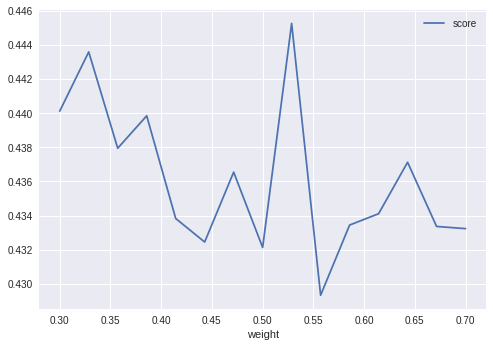

In [0]:
pipe = make_pipeline(
    SMOTE(),
    RandomForestClassifier(n_estimators=25)
)

kf = StratifiedKFold(n_splits = 3)

weights = np.linspace(0.3,0.7,15)

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__ratio': weights
    },
    scoring='f1',
    cv=kf
)
grid_result = gsc.fit(word2vec, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

***Word2Vec + Random Forests + Optimal parameter set of SMOTE ratio***

In [0]:
pipe = make_pipeline(
    SMOTE(random_state=777,ratio=0.5285714285714286),
    RandomForestClassifier()
)

# Fit..
pipe.fit(x_tr, y_tr)

# Predict..
y_pred = pipe.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5945
           1       0.52      0.48      0.50       448

   micro avg       0.93      0.93      0.93      6393
   macro avg       0.74      0.72      0.73      6393
weighted avg       0.93      0.93      0.93      6393



***Fine Tuning Random Forests:-***

Most important hyperparameters of Random Forest:

n_estimators : num of trees

max_features : max number of features considered for splitting a node

max_depth : max number of levels in each decision tree

min_samples_split : min number of data points placed in a node before the node is split

min_samples_leaf : min number of data points allowed in a leaf node

bootstrap : method for sampling data points (with or without replacement)

Let us fine tune no. of estimators and maximum features to be considered usign GridSearchCV


In [0]:
from sklearn.model_selection import GridSearchCV
kf = StratifiedKFold(n_splits = 3)

forest=RandomForestClassifier()

param_grid = [
{'n_estimators': [10,40,50,60],
 'max_features':['auto','sqrt'],
 }
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=kf, scoring='f1',verbose=1,n_jobs=-1)
grid_search_forest.fit(word2vec,y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 40, 50, 60], 'max_features': ['auto', 'sqrt']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [0]:
grid_search_forest.best_estimator_ #Best estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
pipe = make_pipeline(
    SMOTE(random_state=777,ratio=0.5285714285714286),
    grid_search_forest.best_estimator_
)

# Fit..
pipe.fit(x_tr, y_tr)

# Predict..
y_pred = pipe.predict(x_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5945
           1       0.56      0.48      0.52       448

   micro avg       0.94      0.94      0.94      6393
   macro avg       0.76      0.73      0.74      6393
weighted avg       0.93      0.94      0.94      6393



**Observation**

We see that the F1 score has increased after the fine tuning of the parameters.

Lets us approach the problem using ***Deep  Learning***!

***Why Deep Learning?***

a)Deep learning is inspired from our human brain's neuronal structure. Human brain consists of billions of neurons interconnecte to each other. Each neuron receives the signal, processes the signal and pass it on to the other neurons. The same concept is applied here in Deep Learning.

b)Neural Networks are capable of learning any non linear function of weights to map the input to output. Thats why, Neural Networks are called as **Universal Function Approximators**.

c)In traditonal machine learning algorithms, Feature extraction is very important prior to the model building. Extracting most appropriate features one by one requires domain knowledge and time consuming! Here comes the Deep Learning!

***Why LSTM?***

a) The problem with Neural Network is quick generalization and prediction is made by different combinations of inputs. 

b)This is a problem when the prediction has to made by capturing the sequential information from the input rather than trying out different combinations of the input.

c) Here comes RNN. But, RNN's suffer from the vanishing gradient due to which it cannot learn the long term dependencies. Thats why we go with LSTMs.

d) **Long Short Term Memory** models can capture the long range dependencies which is a shortcome of Recurrent Neural Network.

Let us model the problem as Seq2Seq modeling where the input is a sequence of words and output is a class label

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import *
from keras.layers import *
from keras.callbacks import *

x_tr,x_val,y_tr,y_val=train_test_split(np.array(data['cleaned_tweets']),y,test_size=0.2,random_state=77,stratify=y) #Split data into training and validation data initially

## Tokenize the sentences
tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(x_tr))

train_X = tokenizer.texts_to_sequences(x_tr) #Generating sequence with index of the word
val_X = tokenizer.texts_to_sequences(x_val)

## Pad the sentences to max length of sequence so that every sequence is of same length
train_X = pad_sequences(train_X, maxlen=100)
val_X = pad_sequences(val_X, maxlen=100)


In [0]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #padding

***Intrinsic Regularization***

1.Early stopping is a method that allows you to specify an arbitrary large number of training epochs 
and stop training once the model performance stops improving on a hold out validation dataset.

***Extrinsic Regularization***:-

1.Dropout is a regularization method where neurons are randomly dropped from the neural network and weights are not involved during forward propagation as well as the backward propagation.

2.This has the effect of reducing overfitting and improving model performance.

Let us learn the embeddings from the scratch using keras embedding layer.

In [0]:
model=Sequential()
#Every word is projected in 300 dimensional space
#input_length=Maximum length of sequence
#trainable=True represents that embeddings to be learnt during back propagation
model.add(Embedding(size_of_vocabulary,300,input_length=100,trainable=True)) 
model.add(LSTM(32,return_sequences=True,dropout=0.2)) #No. of LSTM cells
model.add(GlobalMaxPooling1D())
model.add(Dense(16,activation='relu')) #No. of hidden nodes
model.add(Dense(1,activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) #Add loss function, metrics, optimizer
#Patience :- Adding a delay in terms of the number of epochs on which we would like to see no improvement.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)  #Early stoppage
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  #To save the best model after every epoch
print(model.summary()) #To know about layers and no. of parameters at each layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          8692200   
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 32)           42624     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 8,735,369
Trainable params: 8,735,369
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(np.array(train_X),np.array(y_tr),batch_size=300,epochs=10,validation_data=(np.array(val_X),np.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 25569 samples, validate on 6393 samples
Epoch 1/10
25569/25569 [==============================] - 21s 805us/step - loss: 0.3174 - acc: 0.9193 - val_loss: 0.2501 - val_acc: 0.9299

Epoch 00001: val_loss improved from inf to 0.25013, saving model to best_model.h5
Epoch 2/10
25569/25569 [==============================] - 19s 749us/step - loss: 0.2248 - acc: 0.9298 - val_loss: 0.1742 - val_acc: 0.9299

Epoch 00002: val_loss improved from 0.25013 to 0.17423, saving model to best_model.h5
Epoch 3/10
25569/25569 [==============================] - 20s 767us/step - loss: 0.1117 - acc: 0.9547 - val_loss: 0.1096 - val_acc: 0.9637

Epoch 00003: val_loss improved from 0.17423 to 0.10962, saving model to best_model.h5
Epoch 4/10
25569/25569 [==============================] - 19s 747us/step - loss: 0.0479 - acc: 0.9864 - val_loss: 0.1120 - val_acc: 0.9625

Epoch 00004: val_loss did not improve from 0.10962
Epoch 5/10
25569/25569 [==============================] - 19s 749us/step - loss: 0.026

***Diagnostic plots***

a)To  Identify whether the model suffers from overfitting, underfitting or good fit with diagnostic plots(No. of epochs vs loss)

b) In case of overfitting, introduce the regularization i.e dropouts in the neural network which randomly drops out few neurons and due to which the rest of the neurons must step in to handle the representation. This leads to better generalization by making the network less sensitive to specific weights of neurons.

c) Incase of underfitting, bring up the reprensentational capacity of the model.

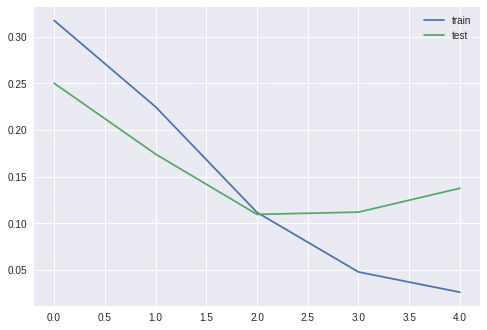

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Observation**:

1.After epoch 3, validation loss keeps increasing as the training loss goes down and we achieve the best model at epoch 3 is saved using Model Checkpoints since the model obtained at the end of epoch is not the best one.

In [0]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

y_pred=model.predict_classes(np.array(val_X))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.88      0.61      0.72       448

   micro avg       0.97      0.97      0.97      6393
   macro avg       0.93      0.80      0.85      6393
weighted avg       0.96      0.97      0.96      6393



In [0]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)

6393/6393 [==============================] - 1s 123us/step


In [0]:
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_val, (pred_noemb_val_y>thresh).astype(int),average='macro')))

F1 score at threshold 0.1 is 0.849444595671083
F1 score at threshold 0.11 is 0.8510824132583207
F1 score at threshold 0.12 is 0.8526033836043214
F1 score at threshold 0.13 is 0.8527495228410886
F1 score at threshold 0.14 is 0.8555452510590422
F1 score at threshold 0.15 is 0.8561726379868686
F1 score at threshold 0.16 is 0.8542669558106444
F1 score at threshold 0.17 is 0.853619519757056
F1 score at threshold 0.18 is 0.8532934632784469
F1 score at threshold 0.19 is 0.8539236336019399
F1 score at threshold 0.2 is 0.8539009861207333
F1 score at threshold 0.21 is 0.8539009861207333
F1 score at threshold 0.22 is 0.8535695616477821
F1 score at threshold 0.23 is 0.8532365102934167
F1 score at threshold 0.24 is 0.8525654790488055
F1 score at threshold 0.25 is 0.8517406709020474
F1 score at threshold 0.26 is 0.8541856027513798
F1 score at threshold 0.27 is 0.8548356844506908
F1 score at threshold 0.28 is 0.8536639875611373
F1 score at threshold 0.29 is 0.8524838078130741
F1 score at threshold 0.

**Observation**

We have achieved the best model with F1 score of 0.85 outperforming all the other models.

**What we have learnt?**

1.What is sentiment Analysis and its use cases?

2.What are the steps that has to be taken for data pre-processing?

3.Exploratory Data Analysis of text

4.Importance of embeddings and its different types

5.How to extract features from text using TF-IDF?

6.How to learn embeddings from the scratch using word2vec?

7.How to handle class imbalance problem?

8.Importance of hyper parameter tuning and how to tune them?

9.Importance of optimal threshold value and how it affects performance?

10.How to model the given problem as Seq2Seq model?

11.Reasons behind LSTM?

12.How to stop training of Neural Network at the right time?

13.How to build deep learning model in keras?

14.Diagnostic plots?

15.How to control overfitting in Neural Networks?
